# 6.1 Networks with metadata

#### In this notebook, we show how to combine metadata with the network structure.

In [ ]:
!git clone https://github.com/mapequation/color-map-equation.git

In [13]:
!cargo build --release --manifest-path color-map-equation/simulate/Cargo.toml

    Finished `release` profile [optimized] target(s) in 0.03s


In [14]:
%load_ext autoreload
%autoreload 2

import subprocess
import os
import glob
from multiprocessing import Pool

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from infomap import Infomap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
cmap = ["#8dd3c7", "#80b1d3", "#fb8072",
        "#b3de69",
        #"#ffffb3",
        "#fdb462",
        "#bebada",
        "#fccde5",
        "#d9d9d9",
        "#bc80bd",
        "#ccebc5",
        "#b15928",
        "#1f78b4"]

def draw(G, pos, square_color=None, circle_color=None):
    nx.draw_networkx_edges(G, pos)
    squares = [node for node, meta in G.nodes.data("metadata") if meta == 1]
    circles = [node for node, meta in G.nodes.data("metadata") if meta == 2]
    nx.draw_networkx_nodes(G, pos, nodelist=squares, node_shape="s", node_color=square_color)
    nx.draw_networkx_nodes(G, pos, nodelist=circles, node_shape="o", node_color=circle_color)

#### Create a toy network example.

In [ ]:
# The network has 7 nodes.
G = nx.Graph([
    (1, 2),
    (2, 3),
    (3, 1),
    (3, 4),
    (4, 5),
    (4, 6),
    (5, 6),
    (5, 7),
    (6, 7)
])

pos = nx.spring_layout(G, seed=27)

In [21]:
# We assign a categorical metadata label to each node
metadata = {
    1: 1,
    2: 1,
    3: 2,
    4: 1,
    5: 2,
    6: 2,
    7: 2
}

nx.set_node_attributes(G, metadata, "metadata")

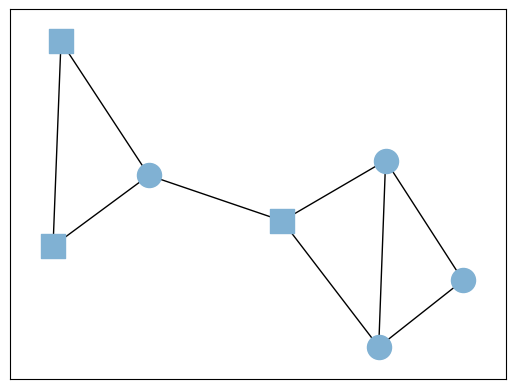

In [ ]:
# Visualize network: label 1 -> circle; label 2 -> square
draw(G, pos, cmap[1], cmap[1])

#### Here, we identify modules using standard map equation.

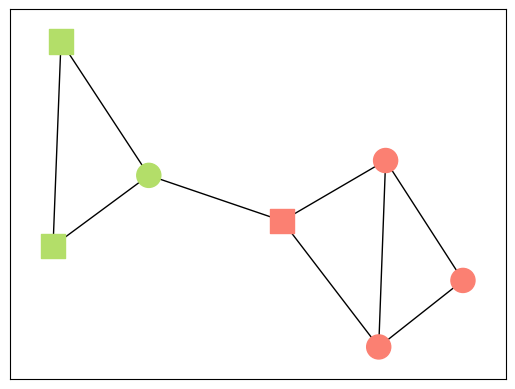

In [19]:
# Without metadata

im = Infomap(directed=False, silent=True, num_trials=1)
im.add_networkx_graph(G)
im.run()

nx.set_node_attributes(G, im.get_modules(), "module")

square_color = [cmap[2] if data["module"] == 1 else cmap[3] for _, data in G.nodes.data(True) if data["metadata"] == 1]
circle_color = [cmap[2] if data["module"] == 1 else cmap[3] for _, data in G.nodes.data(True) if data["metadata"] == 2]

draw(G, pos, square_color, circle_color)

#### Here, we use a metadata-dependent encoding of random walks. 

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.02s
     Running `color-map-equation/simulate/target/debug/simulate -c fig0.net fig0-meta.txt fig0-meta.net 1.0 0.09 1000000`


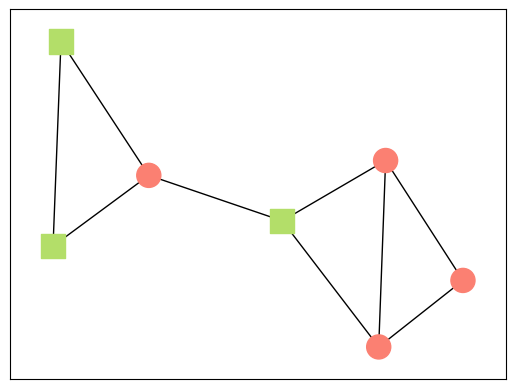

In [22]:
# With metadata

H = nx.DiGraph()
for source, target in G.edges:
    H.add_edge(source, target)
    H.add_edge(target, source)

nx.write_edgelist(H, "fig0.net", data=False)

with open("fig0-meta.txt", "w") as fp:
    for node, meta in G.nodes.data("metadata"):
        fp.write(f"{node} {meta}\n")

p = 0.09

!cargo run --manifest-path color-map-equation/simulate/Cargo.toml -- \
-c fig0.net fig0-meta.txt fig0-meta.net 1.0 {p} 1000000
im = Infomap(flow_model="rawdir", silent=True, num_trials=10)
im.read_file("fig0-meta.net")
im.run()

nx.set_node_attributes(G, im.get_modules(), "module")

square_color = [cmap[2] if data["module"] == 1 else cmap[3] for _, data in G.nodes.data(True) if data["metadata"] == 1]
circle_color = [cmap[2] if data["module"] == 1 else cmap[3] for _, data in G.nodes.data(True) if data["metadata"] == 2]
    
plt.clf()
plt.gca()
draw(G, pos, square_color, circle_color)

### Lazega Lawyers example

In [ ]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

cmap_border = [adjust_lightness(c, 0.4) for c in cmap]

def draw_network(G, pos, **kwargs):
    modules = {node: module - 1
               for node, module in nx.get_node_attributes(G, "modules").items()}
    num_modules = max(modules.values()) + 1

    #cmap = sns.color_palette("deep", num_modules)
    #cmap_border = sns.color_palette("dark", num_modules)

    edge_color = []
    for source, target in G.edges:
        source_module = modules[source]
        target_module = modules[target]
        
        if source_module == target_module:
            edge_color.append(adjust_lightness(cmap[source_module], 0.5))
        else:
            edge_color.append("#cccccc")
        
    nx.draw_networkx_edges(G, pos, alpha=1, edge_color=edge_color, **kwargs)

    for i in (1, 2):
        nodes = [node for node, type_ in G.nodes.data("type") if type_ == i]

        colors = [cmap[modules[node]] for node in nodes]
        edge_colors = [cmap_border[modules[node]] for node in nodes]

        nx.draw_networkx_nodes(G,
                               pos,
                               nodelist=nodes,
                               node_color=colors,
                               edgecolors=edge_colors,
                               node_shape="s" if i == 1 else "o",
                               **kwargs)


In [ ]:
columns = ["seniority", "status", "gender", "office", "years with firm", "age", "practice", "law school"]
attr = pd.read_csv("data/LazegaLawyers/ELattr.dat", sep=r"\s+", names=columns)
attr

A = np.loadtxt("data/LazegaLawyers/ELfriend.dat")
A = A + A.T
A[A > 1] = 1

with open("lazega.net", "w") as f:
    for source, row in enumerate(A):
        for target, weight in enumerate(row):
            if weight > 0:
                f.write(f"{source} {target}\n")

gender = attr["gender"].to_dict()

gender_name = {
    1: "male",
    2: "female"
}

def get_node_name(node):
    return f"{node} {gender_name[gender[node]]}"

with open("lazega.meta", "w") as f:
    for node, gender in gender.items():
        f.write(f"{node} {gender}\n")

H = nx.from_numpy_array(A)
nx.set_node_attributes(H, attr["gender"], "type")
H.remove_nodes_from(list(nx.isolates(H)))
pos = nx.spring_layout(H, seed=27)


In [ ]:
# !rm -rf *.tree *.clu *.json *.temp

same_code_prob = 1
diff_code_prob = [1, 1/4, 1/8]
n_samples = 10**7

# %%time
simulate = "cargo"
args = (
    [
        simulate, "run",
        "--manifest-path", "color-map-equation/simulate/Cargo.toml",
        "--",
        "-c",
        "lazega.net", "lazega.meta", f"lazega_{i}.temp",
        str(same_code_prob),
        str(diff * same_code_prob),
        str(n_samples),
    ]
    for i, diff in enumerate(diff_code_prob)
)

with Pool() as p:
    p.map(subprocess.run, args)
